
Certainly, you can set the target variable to be the sales for a random product on a random date. This approach treats each data point independently, assuming that the features you provide (related to the product and date) are sufficient to predict the sales for that particular product on that specific date.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import Ridge,LinearRegression,LogisticRegression,ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor,BaggingClassifier,ExtraTreesClassifier
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate


# Hiding the warnings
warnings.filterwarnings('ignore')

dataset =pd.read_csv('../Data/DataCoSupplyChainDataset.csv',encoding='latin-1')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# print(tabulate(dataset.head(30), headers='keys', tablefmt='pretty'))



+----+----------+--------------------------+-------------------------------+-------------------+--------------------+-------------------+--------------------+-------------+----------------+----------------+------------------+----------------+----------------+-------------+----------------+-------------------+------------------+----------------+-----------------------------+------------------+---------------+-----------------+-------------+--------------+--------------+------------+---------------+-------------------+-------------------------+----------+------------------------+---------------------+--------------------------+---------------+--------------------------+-------------------------+---------------------+--------+------------------+------------------------+----------------+-----------------------+-----------------+---------------+-----------------+---------------------+---------------------+---------------------------------------------+--------------+---------------+---------

In [2]:
# Sort the DataFrame based on the "DateOrders" column
df_sorted = dataset.sort_values(by='order date (DateOrders)')

# If you want to keep the original index order, you can reset the index
df_sorted.reset_index(drop=True, inplace=True)

df_sorted['order date (DateOrders)'] = pd.to_datetime(df_sorted['order date (DateOrders)'])
df_sorted['shipping date (DateOrders)'] = pd.to_datetime(df_sorted['shipping date (DateOrders)'])

# Create a new column 'operation time' representing the difference between order date and shipping date
df_sorted['operation time'] = df_sorted['shipping date (DateOrders)'] - df_sorted['order date (DateOrders)']

# Set the 'DateOrders' column as the index
df_sorted.set_index('order date (DateOrders)', inplace=True)

df_sorted=df_sorted.drop(columns=['shipping date (DateOrders)'])

df_sorted



,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,Shipping Mode,operation time
order date (DateOrders),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,CASH,2,4,88.790001,239.979996,Advance shipping,0,43,Camping & Hiking,Hickory,EE. UU.,XXXXXXXXX,Mary,11599,Malone,XXXXXXXXX,Consumer,NC,8708 Indian Horse Highway,28601.0,7,Fan Shop,35.776661,-81.362625,LATAM,Mexico City,México,11599,1,957,60.00,0.20,1,299.980011,0.37,1,299.980011,239.979996,88.790001,Central America,Distrito Federal,CLOSED,NaN,957,43,NaN,http://images.acmesports.sports/Diamondback+Wo...,Diamondback Women's Serene Classic Comfort Bi,299.980011,0,Standard Class,2 days
2015-01-01 00:21:00,PAYMENT,3,4,36.470001,107.889999,Advance shipping,0,18,Men's Footwear,Chicago,EE. UU.,XXXXXXXXX,David,256,Rodriguez,XXXXXXXXX,Consumer,IL,7605 Tawny Horse Falls,60625.0,4,Apparel,41.832722,-87.980484,LATAM,Dos Quebradas,Colombia,256,2,403,22.10,0.17,4,129.990005,0.34,1,129.990005,107.889999,36.470001,South America,Risaralda,PENDING_PAYMENT,NaN,403,18,NaN,http://images.acmesports.sports/Nike+Men%27s+C...,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,0,Standard Class,3 days
2015-01-01 00:21:00,PAYMENT,3,4,91.180000,193.990005,Advance shipping,0,48,Water Sports,Chicago,EE. UU.,XXXXXXXXX,David,256,Rodriguez,XXXXXXXXX,Consumer,IL,7605 Tawny Horse Falls,60625.0,7,Fan Shop,41.832722,-87.980484,LATAM,Dos Quebradas,Colombia,256,2,1073,6.00,0.03,2,199.990005,0.47,1,199.990005,193.990005,91.180000,South America,Risaralda,PENDING_PAYMENT,NaN,1073,48,NaN,http://images.acmesports.sports/Pelican+Sunstr...,Pelican Sunstream 100 Kayak,199.990005,0,Standard Class,3 days
2015-01-01 00:21:00,PAYMENT,3,4,68.250000,227.500000,Advance shipping,0,24,Women's Apparel,Chicago,EE. UU.,XXXXXXXXX,David,256,Rodriguez,XXXXXXXXX,Consumer,IL,7605 Tawny Horse Falls,60625.0,5,Golf,41.832722,-87.980484,LATAM,Dos Quebradas,Colombia,256,2,502,22.50,0.09,3,50.000000,0.30,5,250.000000,227.500000,68.250000,South America,Risaralda,PENDING_PAYMENT,NaN,502,24,NaN,http://images.acmesports.sports/Nike+Men%27s+D...,Nike Men's Dri-FIT Victory Golf Polo,50.000000,0,Standard Class,3 days
2015-01-01 10:09:00,PAYMENT,6,4,19.799999,90.000000,Late delivery,1,24,Women's Apparel,Conway,EE. UU.,XXXXXXXXX,Mary,10039,Butler,XXXXXXXXX,Consumer,AR,7786 Quiet Mall,72032.0,5,Golf,35.091896,-92.434547,LATAM,Tegucigalpa,Honduras,10039,30,502,10.00,0.10,88,50.000000,0.22,2,100.000000,90.000000,19.799999,Central America,Francisco Morazán,PENDING_PAYMENT,NaN,502,24,NaN,http://images.acmesports.sports/Nike+Men%27s+D...,Nike Men's Dri-FIT Victory Golf Polo,50.000000,0,Standard Class,6 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 09:08:00,TRANSFER,4,4,4.800000,119.980003,Shipping on time,0,17,Cleats,Caguas,Puerto Rico,XXXXXXXXX,Madison,6352,Smith,XXXXXXXXX,Home Office,PR,4167 Stony Extension,725.0,4,Apparel,18.230684,-66.370529,Europe,Bristol,Reino Unido,6352,67298,365,0.00,0.00,168193,59.990002,0.04,2,119.980003,119.980003,4.800000,Northern Europe,Inglaterra,PROCESSING,NaN,365,17,NaN,http://images.acmesports.

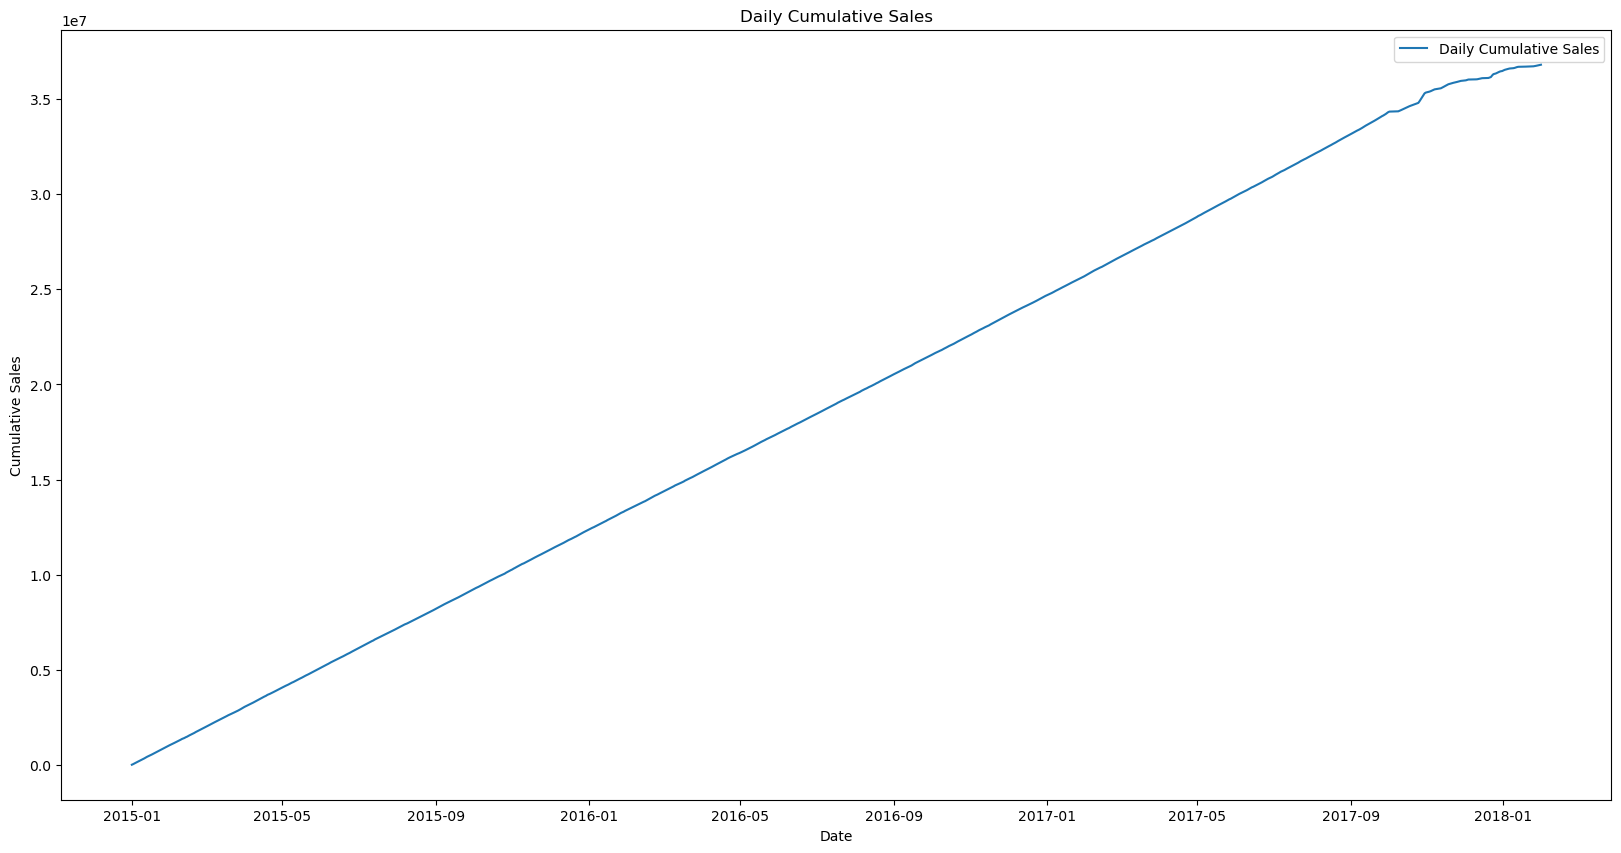

In [3]:
import matplotlib.pyplot as plt

# Assuming df_sorted is your DataFrame filtered for 'South America'
# and 'order date (DateOrders)' is already the index
df_sorted.index = pd.to_datetime(df_sorted.index)

# Group by the date portion of the index and sum the sales
daily_cumulative_sales = df_sorted.resample('D').sum()['Sales'].cumsum()

# Set the figure size
plt.figure(figsize=(20, 10))

# Plot the cumulative sum of daily sales
plt.plot(daily_cumulative_sales.index, daily_cumulative_sales, label='Daily Cumulative Sales')
plt.xlabel('Date')
plt.ylabel('Cumulative Sales')
plt.title('Daily Cumulative Sales')
plt.legend()
plt.show()


['Central America' 'South America' 'Caribbean' 'Southeast Asia'
 'Eastern Asia' 'Oceania' 'South Asia' 'Eastern Europe' 'West Asia'
 'East Africa' 'Central Africa' 'West Africa' 'North Africa'
 'Southern Africa' 'Canada' 'Southern Europe' 'Central Asia'
 'Western Europe' 'Northern Europe' 'South of  USA ' 'West of USA '
 'US Center ' 'East of USA']
                            Type  Days for shipping (real)  Days for shipment (scheduled)  Benefit per order  Sales per customer   Delivery Status  Late_delivery_risk  Category Id         Category Name Customer City Customer Country Customer Email Customer Fname  Customer Id Customer Lname Customer Password Customer Segment Customer State              Customer Street  Customer Zipcode  Department Id Department Name   Latitude   Longitude  Market Order City Order Country  Order Customer Id  Order Id  Order Item Cardprod Id  Order Item Discount  Order Item Discount Rate  Order Item Id  Order Item Product Price  Order Item Profit Ratio  Order I

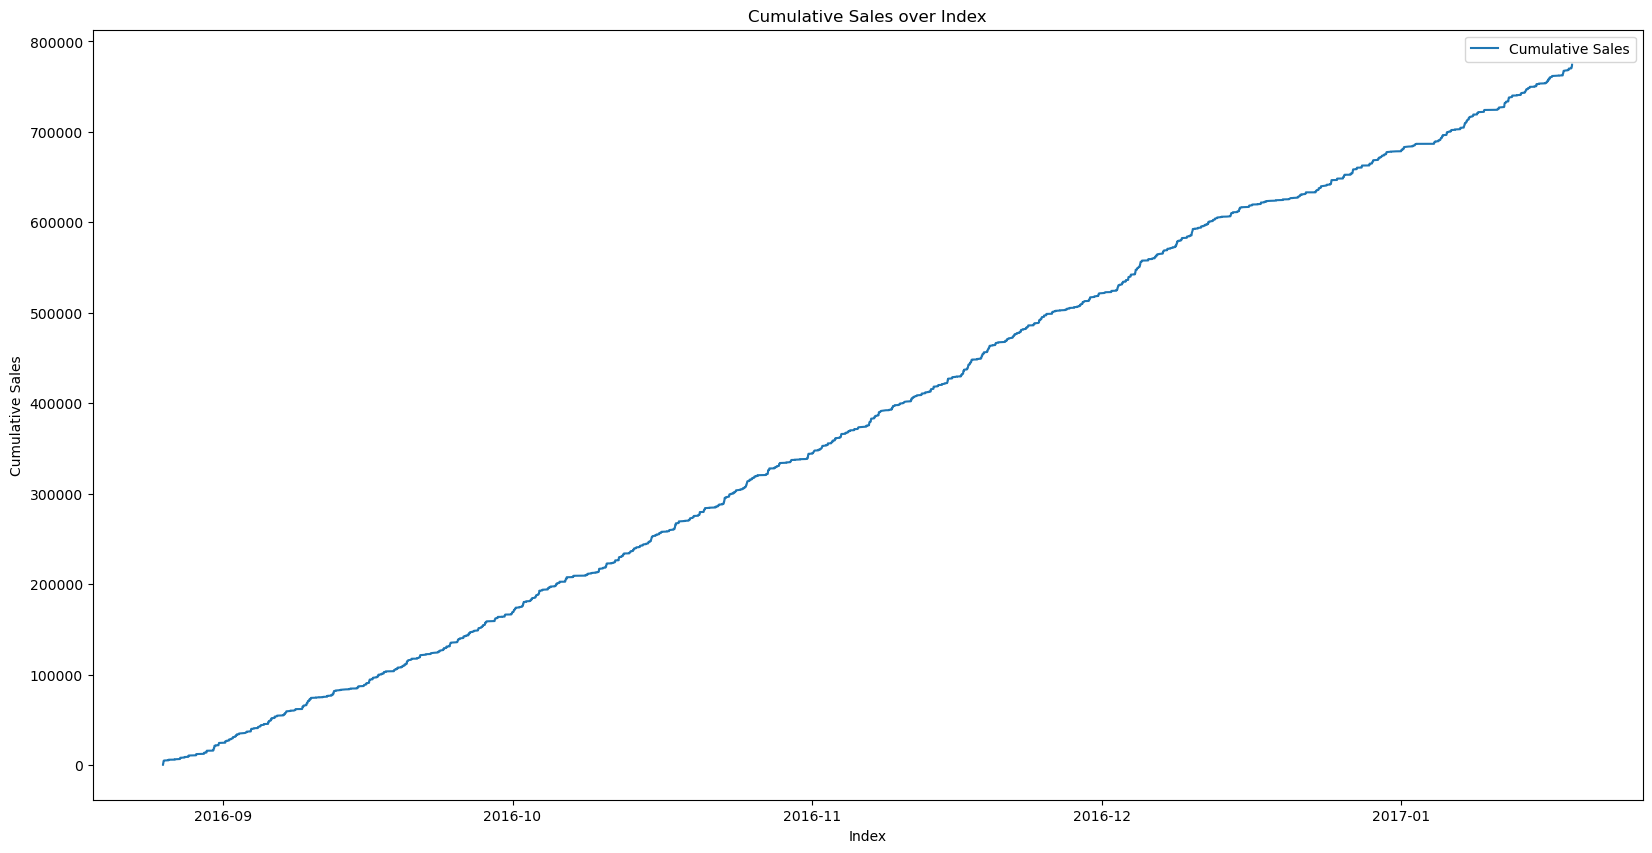

In [4]:
# Assuming df_sorted is your DataFrame
order_regions = df_sorted['Order Region'].unique()

# Print the unique values in 'Order Region' column
print(order_regions)

south_america_orders = df_sorted[df_sorted['Order Region'] == 'Eastern Europe']
# Sort the DataFrame by index
south_america_orders = south_america_orders.sort_index()
print(south_america_orders)

import matplotlib.pyplot as plt

# Assuming south_america_orders is your DataFrame filtered for 'South America'
# and sorted by index
south_america_orders['cumulative_sales'] = south_america_orders['Sales'].cumsum()

# Set the figure size
plt.figure(figsize=(20, 10))

# Plot the cumulative sum of 'Sales'
plt.plot(south_america_orders.index, south_america_orders['cumulative_sales'], label='Cumulative Sales')
plt.xlabel('Index')
plt.ylabel('Cumulative Sales')
plt.title('Cumulative Sales over Index')
plt.legend()
plt.show()


In [5]:
import pandas as pd

# Assuming df_sorted is your DataFrame
# Assuming 'Order Region' is a categorical variable
df_sorted['Order Region'] = df_sorted['Order Region'].astype('category')

# Find unique 'Order Region' values
unique_order_regions = df_sorted['Order Region'].unique()

# Iterate through each unique 'Order Region'
for region in unique_order_regions:
    region_data = df_sorted[df_sorted['Order Region'] == region]
    
    # Convert the index to date without hours and minutes
    region_data.index = region_data.index.date
    
    # Identify existing continuous date ranges day by day
    continuous_ranges = []
    current_range_start = region_data.index[0]
    
    for date in region_data.index[1:]:
        if (date - current_range_start).days == 1:
            current_range_start = date
        else:
            continuous_ranges.append((current_range_start, date - pd.Timedelta(days=1)))
            current_range_start = date
    
    # Add the last continuous range
    continuous_ranges.append((current_range_start, region_data.index[-1]))
    
    # Find the largest continuous range for the current region
    largest_continuous_range = max(continuous_ranges, key=lambda x: (x[1] - x[0]).days + 1)
    largest_range_size = (largest_continuous_range[1] - largest_continuous_range[0]).days + 1

    # Print information about the largest continuous date range for the current region
    print(f"Order Region: {region}")
    print("Largest Continuous Date Range:")
    print(f"Start Date: {largest_continuous_range[0]}")
    print(f"End Date: {largest_continuous_range[1]}")
    print(f"Range Size: {largest_range_size} days")
    print()


Order Region: Central America
Largest Continuous Date Range:
Start Date: 2015-01-18
End Date: 2017-01-17
Range Size: 731 days

Order Region: South America
Largest Continuous Date Range:
Start Date: 2015-01-18
End Date: 2017-01-17
Range Size: 731 days

Order Region: Caribbean
Largest Continuous Date Range:
Start Date: 2015-01-19
End Date: 2017-01-18
Range Size: 731 days

Order Region: Southeast Asia
Largest Continuous Date Range:
Start Date: 2016-01-01
End Date: 2017-12-31
Range Size: 731 days

Order Region: Eastern Asia
Largest Continuous Date Range:
Start Date: 2016-01-01
End Date: 2017-12-31
Range Size: 731 days

Order Region: Oceania
Largest Continuous Date Range:
Start Date: 2016-01-01
End Date: 2017-12-31
Range Size: 731 days

Order Region: South Asia
Largest Continuous Date Range:
Start Date: 2016-01-14
End Date: 2018-01-13
Range Size: 731 days

Order Region: Eastern Europe
Largest Continuous Date Range:
Start Date: 2016-10-03
End Date: 2016-10-29
Range Size: 27 days

Order Regio

In [7]:
# Data processing

dataset['Customer Full Name'] = dataset['Customer Fname'] + dataset['Customer Lname']
dataset['TotalPrice'] = dataset['Order Item Quantity'] * dataset[
    'Sales per customer']  # Multiplying item price * Order quantity

data = dataset.drop(
    ['Customer Email', 'Customer Id', 'Customer Password', 'Customer Fname', 'Customer Lname',
      'Product Description', 'Product Image', 'Order Zipcode','Product Status','Order Profit Per Order','Product Price'], axis=1)

data['Customer Zipcode'] = data['Customer Zipcode'].fillna(0)  # Filling NaN columns with zero


data['order_year'] = pd.DatetimeIndex(data['order date (DateOrders)']).year
data['order_month'] = pd.DatetimeIndex(data['order date (DateOrders)']).month
data['order_week_day'] = pd.DatetimeIndex(data['order date (DateOrders)']).day_name()
data['order_hour'] = pd.DatetimeIndex(data['order date (DateOrders)']).hour
# data['order_second'] = pd.DatetimeIndex(data['order date (DateOrders)'])

data['shipping_year'] = pd.DatetimeIndex(data['shipping date (DateOrders)']).year
data['shipping_month'] = pd.DatetimeIndex(data['shipping date (DateOrders)']).month
data['shipping_week_day'] = pd.DatetimeIndex(data['shipping date (DateOrders)']).day_name()
data['shipping_hour'] = pd.DatetimeIndex(data['shipping date (DateOrders)']).hour

label_data = data[['shipping_week_day','order_week_day','Customer Full Name','Type','Delivery Status','Category Name','Customer City','Customer Country','Customer Segment','Customer State','Customer Street','Department Name','Market','Order City','Order Country','order date (DateOrders)','Order State','Order Status','Product Name','shipping date (DateOrders)','Shipping Mode']]

division = pd.DataFrame()
division['Region'] = data['Order Region']

target=data['Sales']

data=data.drop(columns=['shipping_week_day','order_week_day','Customer Full Name','Sales','Type','Delivery Status','Category Name','Customer City','Customer Country','Customer Segment','Customer State','Customer Street','Department Name','Market','Order City','Order Country','order date (DateOrders)','Order Region','Order State','Order Status','Product Name','shipping date (DateOrders)','Shipping Mode'])


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(tabulate(data.head(30), headers='keys', tablefmt='pretty'))
print(data.shape)


+----+--------------------------+-------------------------------+-------------------+--------------------+--------------------+-------------+------------------+---------------+-------------+--------------+-------------------+----------+------------------------+---------------------+--------------------------+---------------+--------------------------+-------------------------+---------------------+------------------+-----------------+---------------------+-------------+------------+-------------+------------+---------------+----------------+---------------+
|    | Days for shipping (real) | Days for shipment (scheduled) | Benefit per order | Sales per customer | Late_delivery_risk | Category Id | Customer Zipcode | Department Id |  Latitude   |  Longitude   | Order Customer Id | Order Id | Order Item Cardprod Id | Order Item Discount | Order Item Discount Rate | Order Item Id | Order Item Product Price | Order Item Profit Ratio | Order Item Quantity | Order Item Total | Product Card Id

In [8]:

# Preprocess the data
train_data = data
xs = train_data.drop(['Sales'], axis=1)
ys = train_data['Sales']  
xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.3, random_state=42)

# xq=train_data.loc[:, train_data.columns != 'Order Item Quantity']
# yq=train_data['Order Item Quantity']
# xq_train, xq_test,yq_train,yq_test = train_test_split(xq,yq,test_size = 0.3, random_state = 42)

scaler=MinMaxScaler()
xs_train=scaler.fit_transform(xs_train)
xs_test=scaler.transform(xs_test)
# xq_train=scaler.fit_transform(xq_train)
# xq_test=scaler.transform(xq_test)


train_inputs = torch.tensor(xs_train, dtype=torch.float32)
train_targets = torch.tensor(ys_train.values, dtype=torch.float32)
test_inputs = torch.tensor(xs_test, dtype=torch.float32)
test_targets = torch.tensor(ys_test.values, dtype=torch.float32)


KeyError: "['Sales'] not found in axis"

In [ ]:

def Labelencoder_feature(x):
    le=LabelEncoder()
    x=le.fit_transform(x)
    return x

# Apply label encoding to remaining columns
data_encoded = label_data.apply(Labelencoder_feature)

data = pd.concat([data_encoded, data], axis=1)


# Calculate correlation matrix
correlation_matrix = data.corr()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(data.head(100))
print(data.shape)



# Create heatmap
plt.figure(figsize=(100, 50))
sns.heatmap(correlation_matrix, annot=True, fmt=".3f", cmap="BuPu")
plt.show()


data1 = pd.concat([data,division], axis=1)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(data1.head(100))
print(data1.shape)
